In [1]:
 import os
import sys
import numpy as np

sys.path.append('/home/john/Mask_RCNN/')
sys.path.append('/home/john/Mask_RCNN/maskrcnn/')
sys.path.append('/home/john/Mask_RCNN/cocoapi/PythonAPI/')

import matplotlib
matplotlib.use('Agg')
#%matplotlib inline 
import matplotlib.pyplot as plt

import utils
import skimage.io
from maskrcnn import model as modellib
from maskrcnn import visualize
from model import log

# MS COCO Dataset
import coco
print('coco lib path:{}'.format(coco.__file__))

# Coco Dataset Config
config = coco.CocoConfig()

class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()

# define path of coco dataset
COCO_DIR = "/data1/coco/2017"

### Setup Model
# Root directory of the project
ROOT_DIR = "/home/john/Mask_RCNN"

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_DIR = os.path.join(ROOT_DIR, "weights")
if not os.path.exists(COCO_MODEL_DIR):
        os.makedirs(COCO_MODEL_DIR)
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "weights/mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
        utils.download_trained_weights(COCO_MODEL_PATH)

# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
print("!!! Loading weights of model !!!")
model.load_weights(COCO_MODEL_PATH, by_name=True)


### Load Dataset
if config.NAME == 'shapes':
    dataset = shapes.ShapesDataset()
    dataset.load_shapes(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
elif config.NAME == "coco":
    dataset = coco.CocoDataset()
    print('start load coco model {}'.format(COCO_DIR))
    dataset.load_coco(COCO_DIR, "val")


# Prepare data
dataset.prepare()
print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))

"""
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))
"""

def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax


def get_unique_id_list(input_list):
    """
    get unique id in input list,
    filter duplicate item, return >=0 interger
    """
    rtn_list = []

    for i in input_list:
        if i not in rtn_list and i >= 0:
            rtn_list.append(i)
    return rtn_list


# Load and display random samples
image_ids = np.random.choice(dataset.image_ids, 1)

for image_id in image_ids:
    print('----------------------------------')
    image = dataset.load_image(image_id)
   
    # Parse image additional info           
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
    info = dataset.image_info[image_id]
    print("Processing image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
    
    # Detect
    results = model.detect([image], verbose=0)
    ax = get_ax(1)
    r = results[0]
    





Using TensorFlow backend.


coco lib path:/home/john/Mask_RCNN/coco.py
!!! Loading weights of model !!!
start load coco model /data1/coco/2017
loading annotations into memory...
Done (t=0.89s)
creating index...
index created!
Image Count: 4952
Class Count: 81
----------------------------------
Processing image ID: coco.13729 (3336) http://cocodataset.org/#explore?id=13729


overlaps shape (3, 2) overlaps [[ 0.84615385  0.        ]
 [ 0.          0.81195909]
 [ 0.01023041  0.01737466]]
john pred_match [ 1.  1.  0.] len 3
gt_match: [ 1.  1.] len 2
john precisions [ 1.          1.          0.66666667]
john recalls [ 0.5  1.   1. ]
score flag False, AP =====>  1.0
gt_class_id  [11 12]
precisions [ 1.          1.          1.          0.66666667  0.        ]
recalls [ 0.   0.5  1.   1.   1. ]


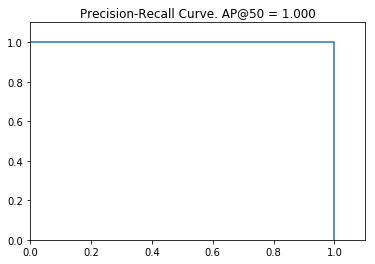

In [6]:
    # Calculate each object accuracy
    
    AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, 
                                          r['rois'], r['class_ids'], r['scores'])
    print("score flag False, AP =====> ", AP)
    print("gt_class_id ", gt_class_id)
    print("precisions", precisions)
    print("recalls", recalls)

    visualize.plot_precision_recall(AP, precisions, recalls)


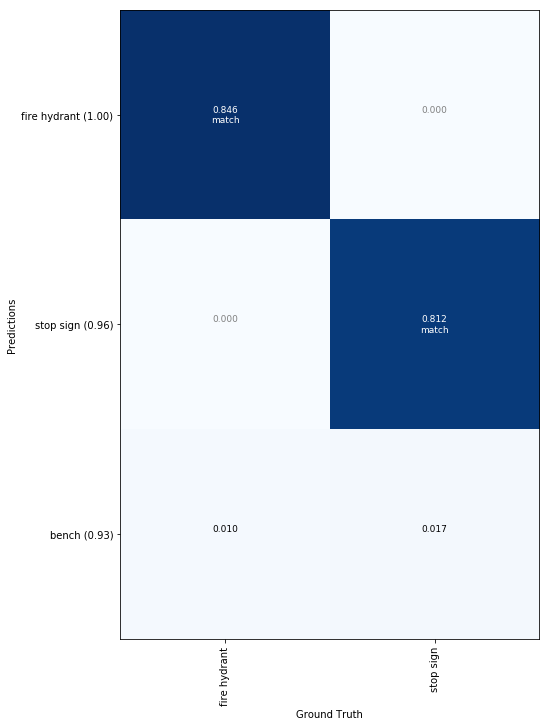

In [7]:
# Grid of ground truth objects and their predictions
visualize.plot_overlaps(gt_class_id, r['class_ids'], r['scores'],
                        overlaps, dataset.class_names)